In [2]:
from finlab.data import Data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as sco
import numpy as np
data = Data()
price = data.get('收盤價',500)
%matplotlib inline

In [21]:
selects = ['6281','2028','2408','9945','4755','2636','1305','3312','1227', '2385', '2477', '3665', '5388', '6412','2327']
table = price[selects[0:len(selects)]]
table.head()

stock_id,6281,2028,2408,9945,4755,2636,1305,3312,1227,2385,2477,3665,5388,6412,2327
date,,,,,,,,,,,,,,,
2016-10-12,60.3,1.80,40.25,37.25,30.85,NaN,21.95,7.14,82.3,79.7,13.95,162.5,72.1,46.35,63.0
2016-10-13,60.4,1.75,40.15,36.95,30.80,NaN,23.00,7.16,80.8,79.9,13.85,159.5,71.2,46.95,62.5
2016-10-14,60.0,1.68,39.30,36.65,30.80,NaN,23.10,7.14,79.6,78.6,13.75,161.0,69.1,48.40,62.0
2016-10-17,60.3,1.68,39.40,36.25,30.85,NaN,22.80,7.15,78.6,79.6,13.65,163.0,71.8,48.80,62.0
2016-10-18,60.3,1.68,39.45,36.85,31.25,NaN,22.15,7.06,78.8,80.1,13.60,157.5,71.8,50.10,62.0


In [22]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252 #trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate,n_stocks):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(n_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record
#simple returns
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178
n_stocks = len(selects)

In [23]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate , n_stocks)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [24]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate,n_stocks)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.34
Annualised Volatility: 0.2


stock_id    6281   2028  2408   9945   4755   2636  1305  3312  1227  2385  \
allocation  6.11  13.53   6.8  15.73  15.31  10.96  2.13  2.65   0.3  7.14   

stock_id    2477  3665  5388  6412   2327  
allocation  0.46  0.44  0.54  1.65  16.26  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.12


stock_id     6281  2028  2408  9945  4755  2636  1305  3312   1227   2385  \
allocation  12.19   4.6  4.79   6.0  5.49  8.01  6.42  3.98  11.62  12.82   

stock_id    2477  3665  5388   6412  2327  
allocation  2.18  2.46  5.88  13.55  0.01  


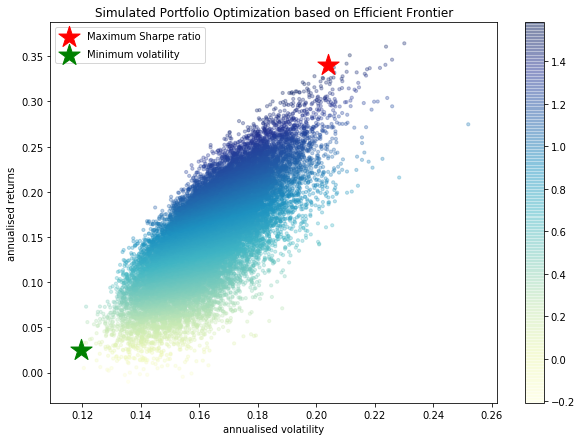

In [25]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks)

In [26]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.74
Annualised Volatility: 0.36


stock_id    6281  2028  2408  9945  4755  2636  1305  3312  1227  2385   2477  \
allocation   0.0  40.2   0.0  3.13   0.0   0.0   0.0  8.95   0.0   0.0  14.82   

stock_id    3665  5388  6412  2327  
allocation   0.0   0.0   0.0  32.9  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.03
Annualised Volatility: 0.08


stock_id     6281  2028  2408  9945  4755  2636  1305  3312   1227  2385  \
allocation  58.61   0.0   0.0  2.99  0.97  3.82  0.73  2.99  13.55  9.03   

stock_id    2477  3665  5388  6412  2327  
allocation  0.98   0.0  2.13   4.2   0.0  


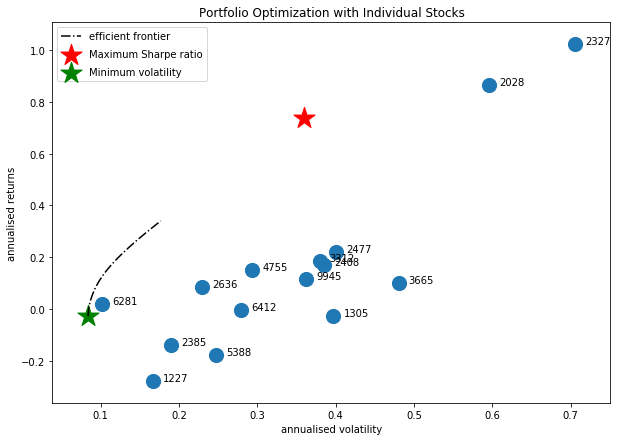

In [27]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate,n_stocks):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate,n_stocks)

In [10]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate,n_stocks)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.48
Annualised Volatility: 0.3


stock_id    6281   2028  2408  9945  4755  2636  1305   3312  1227  2385  \
allocation   0.0  44.05  6.95  6.06  8.15  1.31   0.0  14.95   0.0   0.0   

stock_id     2477  3665  5388  6412  
allocation  18.54   0.0   0.0   0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.03
Annualised Volatility: 0.08


stock_id    6281  2028  2408  9945  4755  2636  1305  3312   1227  2385  2477  \
allocation  58.6  0.01   0.0  2.98  0.97  3.82  0.73  2.99  13.55  9.03  0.98   

stock_id    3665  5388  6412  
allocation   0.0  2.14  4.19  


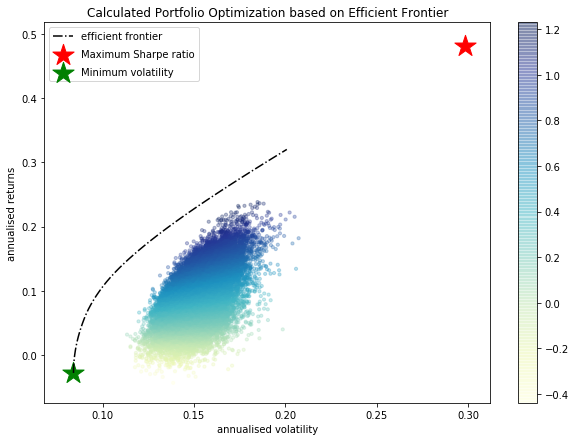

In [11]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate,n_stocks)

In [23]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

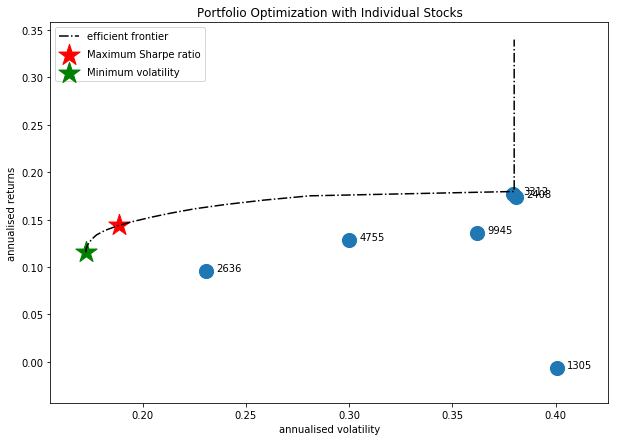

In [24]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)